# Graph Construction and Visualization
This script builds a heterogeneous graph (Knowledge Graph) using NetworkX.
It integrates:
1. Users (from MovieLens)
2. Movies (enriched from TMDB)
3. Ratings (User-Movie edges)
4. Content Metadata (Directors, Writers, Genres, Keywords)

In [28]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random

# Configuration
USER_FILE = '../data/raw/ml-100k/u.user'
RATINGS_FILE = '../data/raw/ml-100k/u1.base' # Using the training split as requested
MOVIES_FILE = '../data/processed/movies_graph_ready.csv'
NODES_DIR = '../data/processed/nodes'

# Graph Instance
G = nx.Graph()

## 1. Load Data Frames
We load all necessary CSVs into Pandas DataFrames first to inspect them.

In [29]:
# Load Users (Pipe separated)
# Columns: user id | age | gender | occupation | zip code
try:
    users_df = pd.read_csv(USER_FILE, sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip'], encoding='latin-1')
    print(f"Loaded {len(users_df)} users.")
except FileNotFoundError:
    print(f"Error: User file not found at {USER_FILE}")

# Load Ratings (Tab separated)
# Columns: user id | item id | rating | timestamp
try:
    ratings_df = pd.read_csv(RATINGS_FILE, sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
    print(f"Loaded {len(ratings_df)} ratings.")
except FileNotFoundError:
    print(f"Error: Ratings file not found at {RATINGS_FILE}")

# Load Movies (Processed CSV)
try:
    movies_df = pd.read_csv(MOVIES_FILE)
    print(f"Loaded {len(movies_df)} movies.")
except FileNotFoundError:
    print(f"Error: Movies file not found at {MOVIES_FILE}")

Loaded 943 users.
Loaded 80000 ratings.
Loaded 1638 movies.


## 2. Node Creation Helpers
We define prefixes to ensure unique IDs across different entity types (e.g. User 1 != Movie 1).


In [30]:
def add_nodes_from_df(graph, df, node_type, id_col, prefix, attr_cols=[]):
    """
    Adds nodes to the graph from a dataframe.
    """
    count = 0
    for _, row in df.iterrows():
        node_id = f"{prefix}_{row[id_col]}"
        
        # base attributes
        attrs = {'type': node_type}
        
        # additional attributes from columns
        for col in attr_cols:
            if col in row and pd.notna(row[col]):
                attrs[col] = row[col]
        
        graph.add_node(node_id, **attrs)
        count += 1
    return count

## 3. Add User Nodes
Adding users from the MovieLens dataset.

In [31]:
print("Adding User nodes...")
user_count = add_nodes_from_df(
    G, 
    users_df, 
    node_type="user", 
    id_col="user_id", 
    prefix="user", 
    attr_cols=["age", "gender", "occupation"]
)
print(f"Added {user_count} User nodes.")

Adding User nodes...
Added 943 User nodes.


## 4. Add Movie Nodes
Adding movies from our enriched dataset.

In [32]:
print("Adding Movie nodes...")
movie_count = add_nodes_from_df(
    G, 
    movies_df, 
    node_type="movie", 
    id_col="ml_movie_id", 
    prefix="movie", 
    attr_cols=["title", "release_year", "vote_average", "popularity", "budget", "runtime"]
)
print(f"Added {movie_count} Movie nodes.")

Adding Movie nodes...
Added 1638 Movie nodes.


## 5. Add Content Entity Nodes (Genres, Keywords, Crew)
We iterate through the auxiliary files to create the metadata nodes.

In [33]:
# Helper to load node CSVs if they exist
def load_node_csv(filename):
    path = os.path.join(NODES_DIR, filename)
    if os.path.exists(path):
        return pd.read_csv(path)
    print(f"Warning: {filename} not found.")
    return pd.DataFrame()

# 5a. Genres
genres_df = load_node_csv('genres.csv')
genre_count = add_nodes_from_df(G, genres_df, "genre", "id", "genre", ["name"])
print(f"Added {genre_count} Genre nodes.")

# 5b. Keywords
keywords_df = load_node_csv('keywords.csv')
keyword_count = add_nodes_from_df(G, keywords_df, "keyword", "id", "keyword", ["name"])
print(f"Added {keyword_count} Keyword nodes.")

# 5c. Directors
directors_df = load_node_csv('directors.csv')
director_count = add_nodes_from_df(G, directors_df, "director", "id", "director", ["name"])
print(f"Added {director_count} Director nodes.")

# 5d. Writers
writers_df = load_node_csv('writers.csv')
writer_count = add_nodes_from_df(G, writers_df, "writer", "id", "writer", ["name"])
print(f"Added {writer_count} Writer nodes.")

Added 19 Genre nodes.
Added 5985 Keyword nodes.
Added 1028 Director nodes.
Added 2551 Writer nodes.


## 6. Add Edges: Users -> [RATED] -> Movies
We use the ratings dataframe. We only add edges if both nodes exist (to be safe).

In [34]:
print("Adding User-Movie rating edges...")
edge_count = 0
missing_nodes = 0

for _, row in ratings_df.iterrows():
    user_node = f"user_{int(row['user_id'])}"
    movie_node = f"movie_{int(row['movie_id'])}"
    
    if G.has_node(user_node) and G.has_node(movie_node):
        G.add_edge(user_node, movie_node, relation="rated", weight=row['rating'], timestamp=row['timestamp'])
        edge_count += 1
    else:
        missing_nodes += 1

print(f"Added {edge_count} RATED edges.")
if missing_nodes > 0:
    print(f"Skipped {missing_nodes} edges due to missing nodes (likely movies not in our enriched subset).")


Adding User-Movie rating edges...
Added 79298 RATED edges.
Skipped 702 edges due to missing nodes (likely movies not in our enriched subset).


## 7. Add Edges: Movies -> [HAS_METADATA] -> Entities
We iterate through the movies dataframe again, parsing the JSON ID lists to link movies to their content attributes.

In [35]:
print("Adding Content-based edges...")
content_edges = 0
error_count = 0

for _, row in movies_df.iterrows():
    movie_node = f"movie_{int(row['ml_movie_id'])}"
    
    if not G.has_node(movie_node):
        continue

    # Helper to safely load list and add edges
    def add_meta_edges(col_name, prefix, relation):
        count = 0
        try:
            ids = json.loads(row[col_name])
            if isinstance(ids, list):
                for item_id in ids:
                    target_node = f"{prefix}_{item_id}"
                    if G.has_node(target_node):
                        G.add_edge(movie_node, target_node, relation=relation)
                        count += 1
        except Exception:
            pass
        return count

    # Add edges
    content_edges += add_meta_edges('genres', 'genre', 'has_genre')
    content_edges += add_meta_edges('keywords', 'keyword', 'has_keyword')
    content_edges += add_meta_edges('directors', 'director', 'directed_by')
    content_edges += add_meta_edges('writers', 'writer', 'written_by')

print(f"Added {content_edges} content metadata edges.")

Adding Content-based edges...
Added 23055 content metadata edges.


## 8. Graph Statistics
Let's look at the scale of what we built.

In [36]:
print("-" * 30)
print("GRAPH STATISTICS")
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")
print("-" * 30)

# Count by type
node_types = {}
for n, attr in G.nodes(data=True):
    t = attr.get('type', 'unknown')
    node_types[t] = node_types.get(t, 0) + 1

for t, c in node_types.items():
    print(f"Nodes of type '{t}': {c}")

------------------------------
GRAPH STATISTICS
Total Nodes: 12164
Total Edges: 101951
------------------------------
Nodes of type 'user': 943
Nodes of type 'movie': 1638
Nodes of type 'genre': 19
Nodes of type 'keyword': 5985
Nodes of type 'director': 1028
Nodes of type 'writer': 2551


## 9. Visualization (Tripartite Layout)
We will visualize the neighborhood using a fixed 3-column layout to reduce clutter.
Column 1: Users
Column 2: Movies
Column 3: Attributes (Genres, Keywords, Crew)

Extracting neighborhood for User 1...


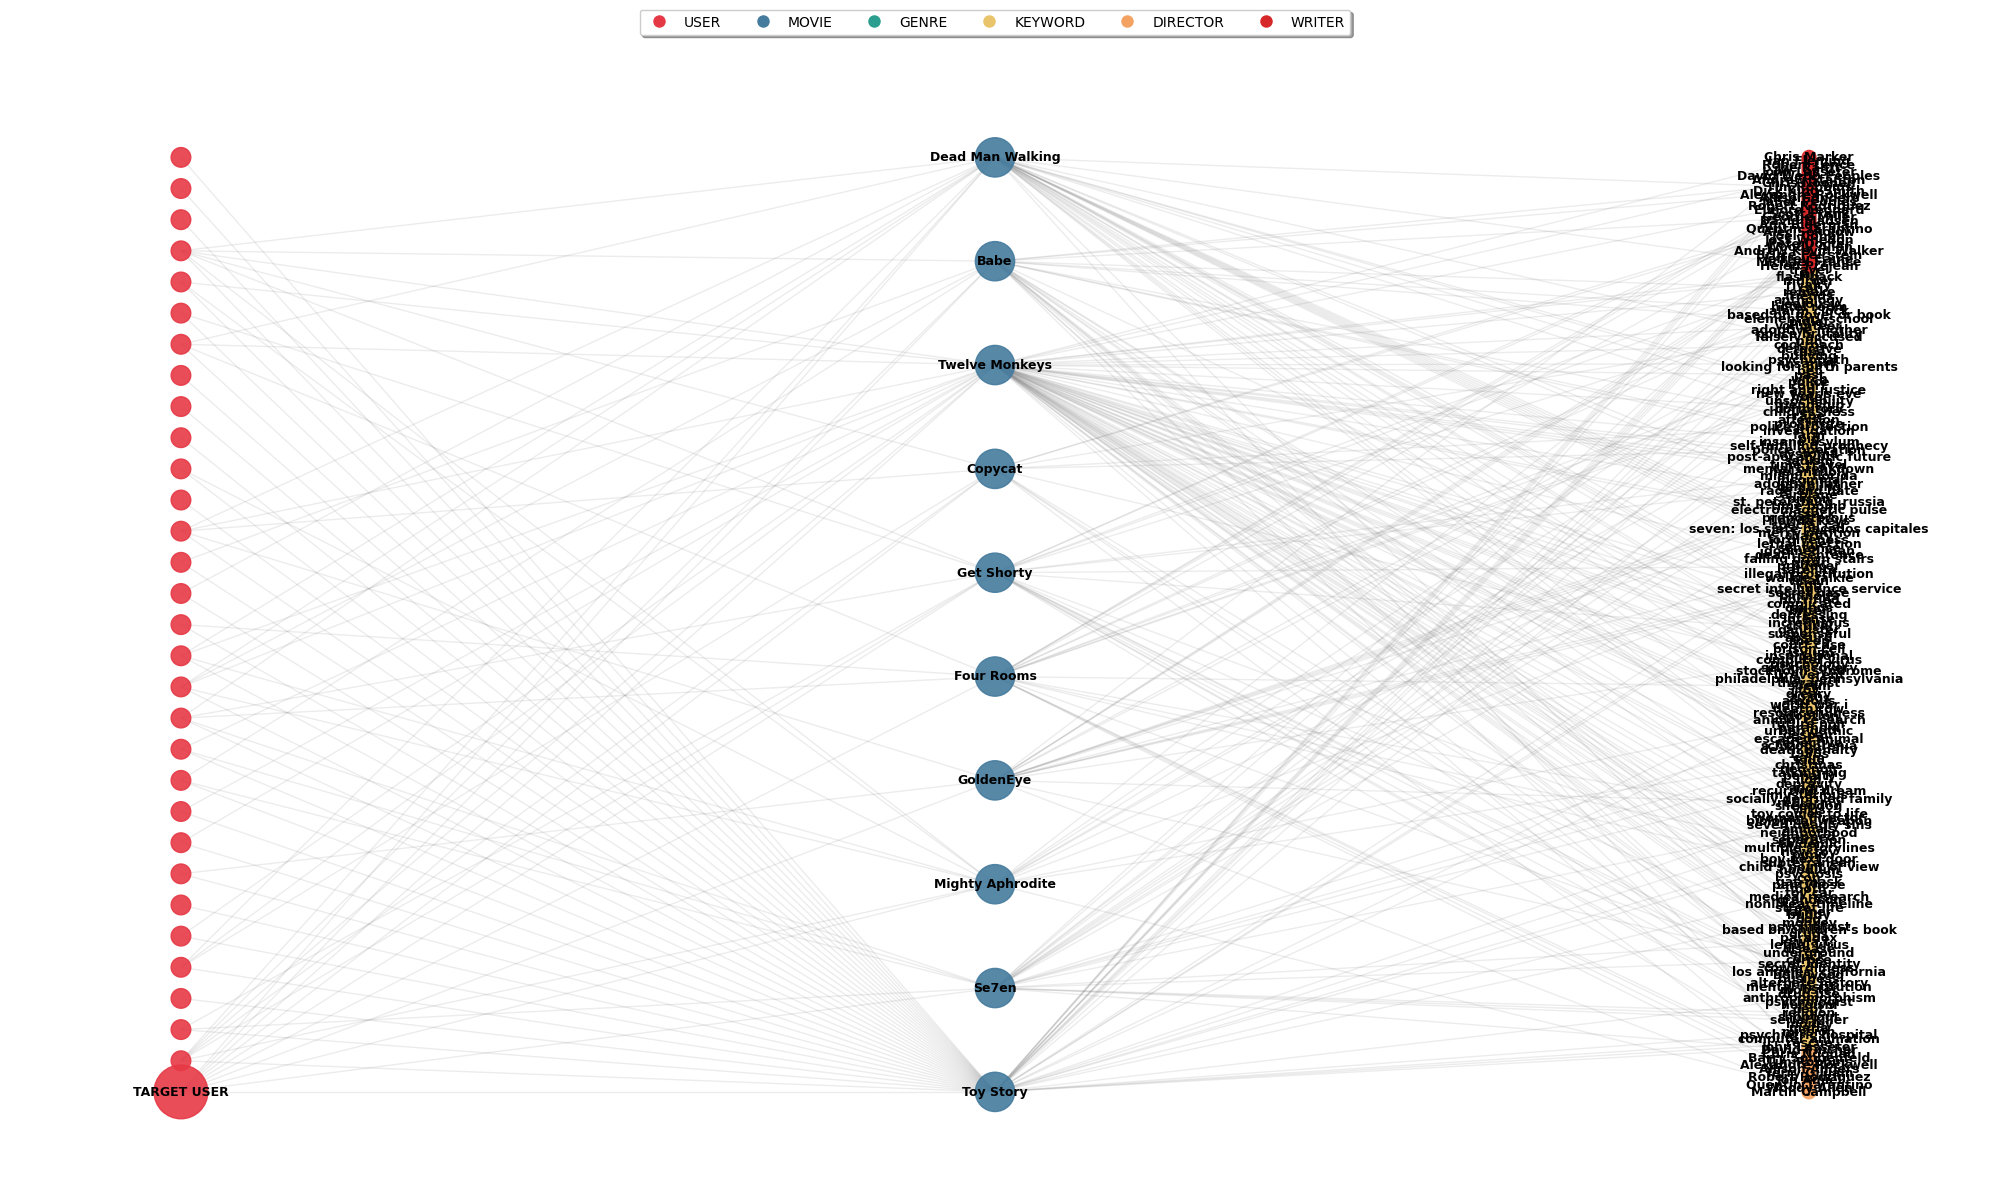

In [37]:
def visualize_tripartite_neighborhood(graph, user_id):
    target_user = f"user_{user_id}"
    
    if not graph.has_node(target_user):
        print(f"User {user_id} not found.")
        return

    print(f"Extracting neighborhood for User {user_id}...")
    
    # 1. Identify Nodes for Subgraph
    
    # Neighbors of Target User (Movies Watched)
    movies_watched = list(graph.neighbors(target_user))
    
    # Sample movies to keep plot readable (limit to 10 movies for this view)
    movies_to_plot = movies_watched[:10] 
    
    subgraph_nodes = {target_user}
    subgraph_nodes.update(movies_to_plot)
    
    # Fetch secondary connections (Attributes and Other Users)
    other_users = set()
    attributes = set()

    for m in movies_to_plot:
        neighbors = list(graph.neighbors(m))
        for n in neighbors:
            ntype = graph.nodes[n].get('type')
            
            # If it's a user (who isn't the target), add to "Other Users" list
            if ntype == 'user' and n != target_user:
                if len(other_users) < 30: # HARD LIMIT to prevent clutter
                    other_users.add(n)
            
            # If it's an attribute, add to Attributes list
            elif ntype in ['genre', 'keyword', 'director', 'writer']:
                attributes.add(n)
    
    subgraph_nodes.update(other_users)
    subgraph_nodes.update(attributes)
    
    # Create subgraph
    subG = graph.subgraph(subgraph_nodes)
    
    # 2. Calculate Positions (Tripartite Layout)
    pos = {}
    
    # Group nodes by column
    # Target user goes in the middle of the User column
    col_users = list(other_users) + [target_user]
    col_movies = movies_to_plot
    col_attrs = list(attributes)
    
    # Sort for visual consistency
    col_users.sort()
    col_movies.sort()
    col_attrs.sort() # Ideally sort by type, then name
    
    # Helper to assign (x, y)
    def assign_column_positions(nodes, x_val):
        n = len(nodes)
        if n == 0: return
        # Linear spacing from y=0.1 to y=0.9
        ys = np.linspace(0.1, 0.9, n)
        for i, node in enumerate(nodes):
            pos[node] = np.array([x_val, ys[i]])

    # Assign X coordinates: Users=0, Movies=1, Attributes=2
    assign_column_positions(col_users, 0)
    assign_column_positions(col_movies, 1)
    assign_column_positions(col_attrs, 2)
    
    # 3. Visualization
    plt.figure(figsize=(20, 12))
    
    # Colors
    type_colors = {
        'user': '#e63946',      # Red
        'movie': '#457b9d',     # Blue
        'genre': '#2a9d8f',     # Teal
        'keyword': '#e9c46a',   # Yellow/Orange
        'director': '#f4a261',  # Orange
        'writer': '#d62828'     # Dark Red
    }
    
    # Draw Edges (Light grey background lines)
    nx.draw_networkx_edges(subG, pos, alpha=0.15, edge_color='gray')
    
    # Draw Nodes by Type
    for ntype in ['user', 'movie', 'attribute']:
        if ntype == 'attribute':
            nodelist = col_attrs
            size = 100
        elif ntype == 'movie':
            nodelist = col_movies
            size = 800
        else:
            nodelist = col_users
            size = 200 # Small for other users
            
        if not nodelist: continue
        
        # Color map for this batch
        colors = [type_colors.get(subG.nodes[n].get('type'), '#cccccc') for n in nodelist]
        
        # Highlight target user
        sizes = []
        for n in nodelist:
            if n == target_user: sizes.append(1500)
            else: sizes.append(size)
            
        nx.draw_networkx_nodes(subG, pos, nodelist=nodelist, node_color=colors, node_size=sizes, alpha=0.9)
    
    # Draw Labels
    labels = {}
    for node in subG.nodes():
        ntype = subG.nodes[node].get('type')
        
        # Label Logic:
        # 1. Target User: ALWAYS label
        # 2. Movies: ALWAYS label (Title)
        # 3. Attributes: ALWAYS label (Name)
        # 4. Other Users: NEVER label (Reduces clutter)
        
        if node == target_user:
            labels[node] = "TARGET USER"
        elif ntype == 'user':
            continue 
        elif ntype == 'movie':
            labels[node] = subG.nodes[node].get('title', node)
        else:
            labels[node] = subG.nodes[node].get('name', node)
            
    nx.draw_networkx_labels(subG, pos, labels, font_size=9, font_weight='bold', font_family='sans-serif')
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=k.upper(),
                          markerfacecolor=v, markersize=10) for k, v in type_colors.items()]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=len(type_colors), fancybox=True, shadow=True)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run visualization for User 1
visualize_tripartite_neighborhood(G, 1)

Extracting neighborhood for User 1...


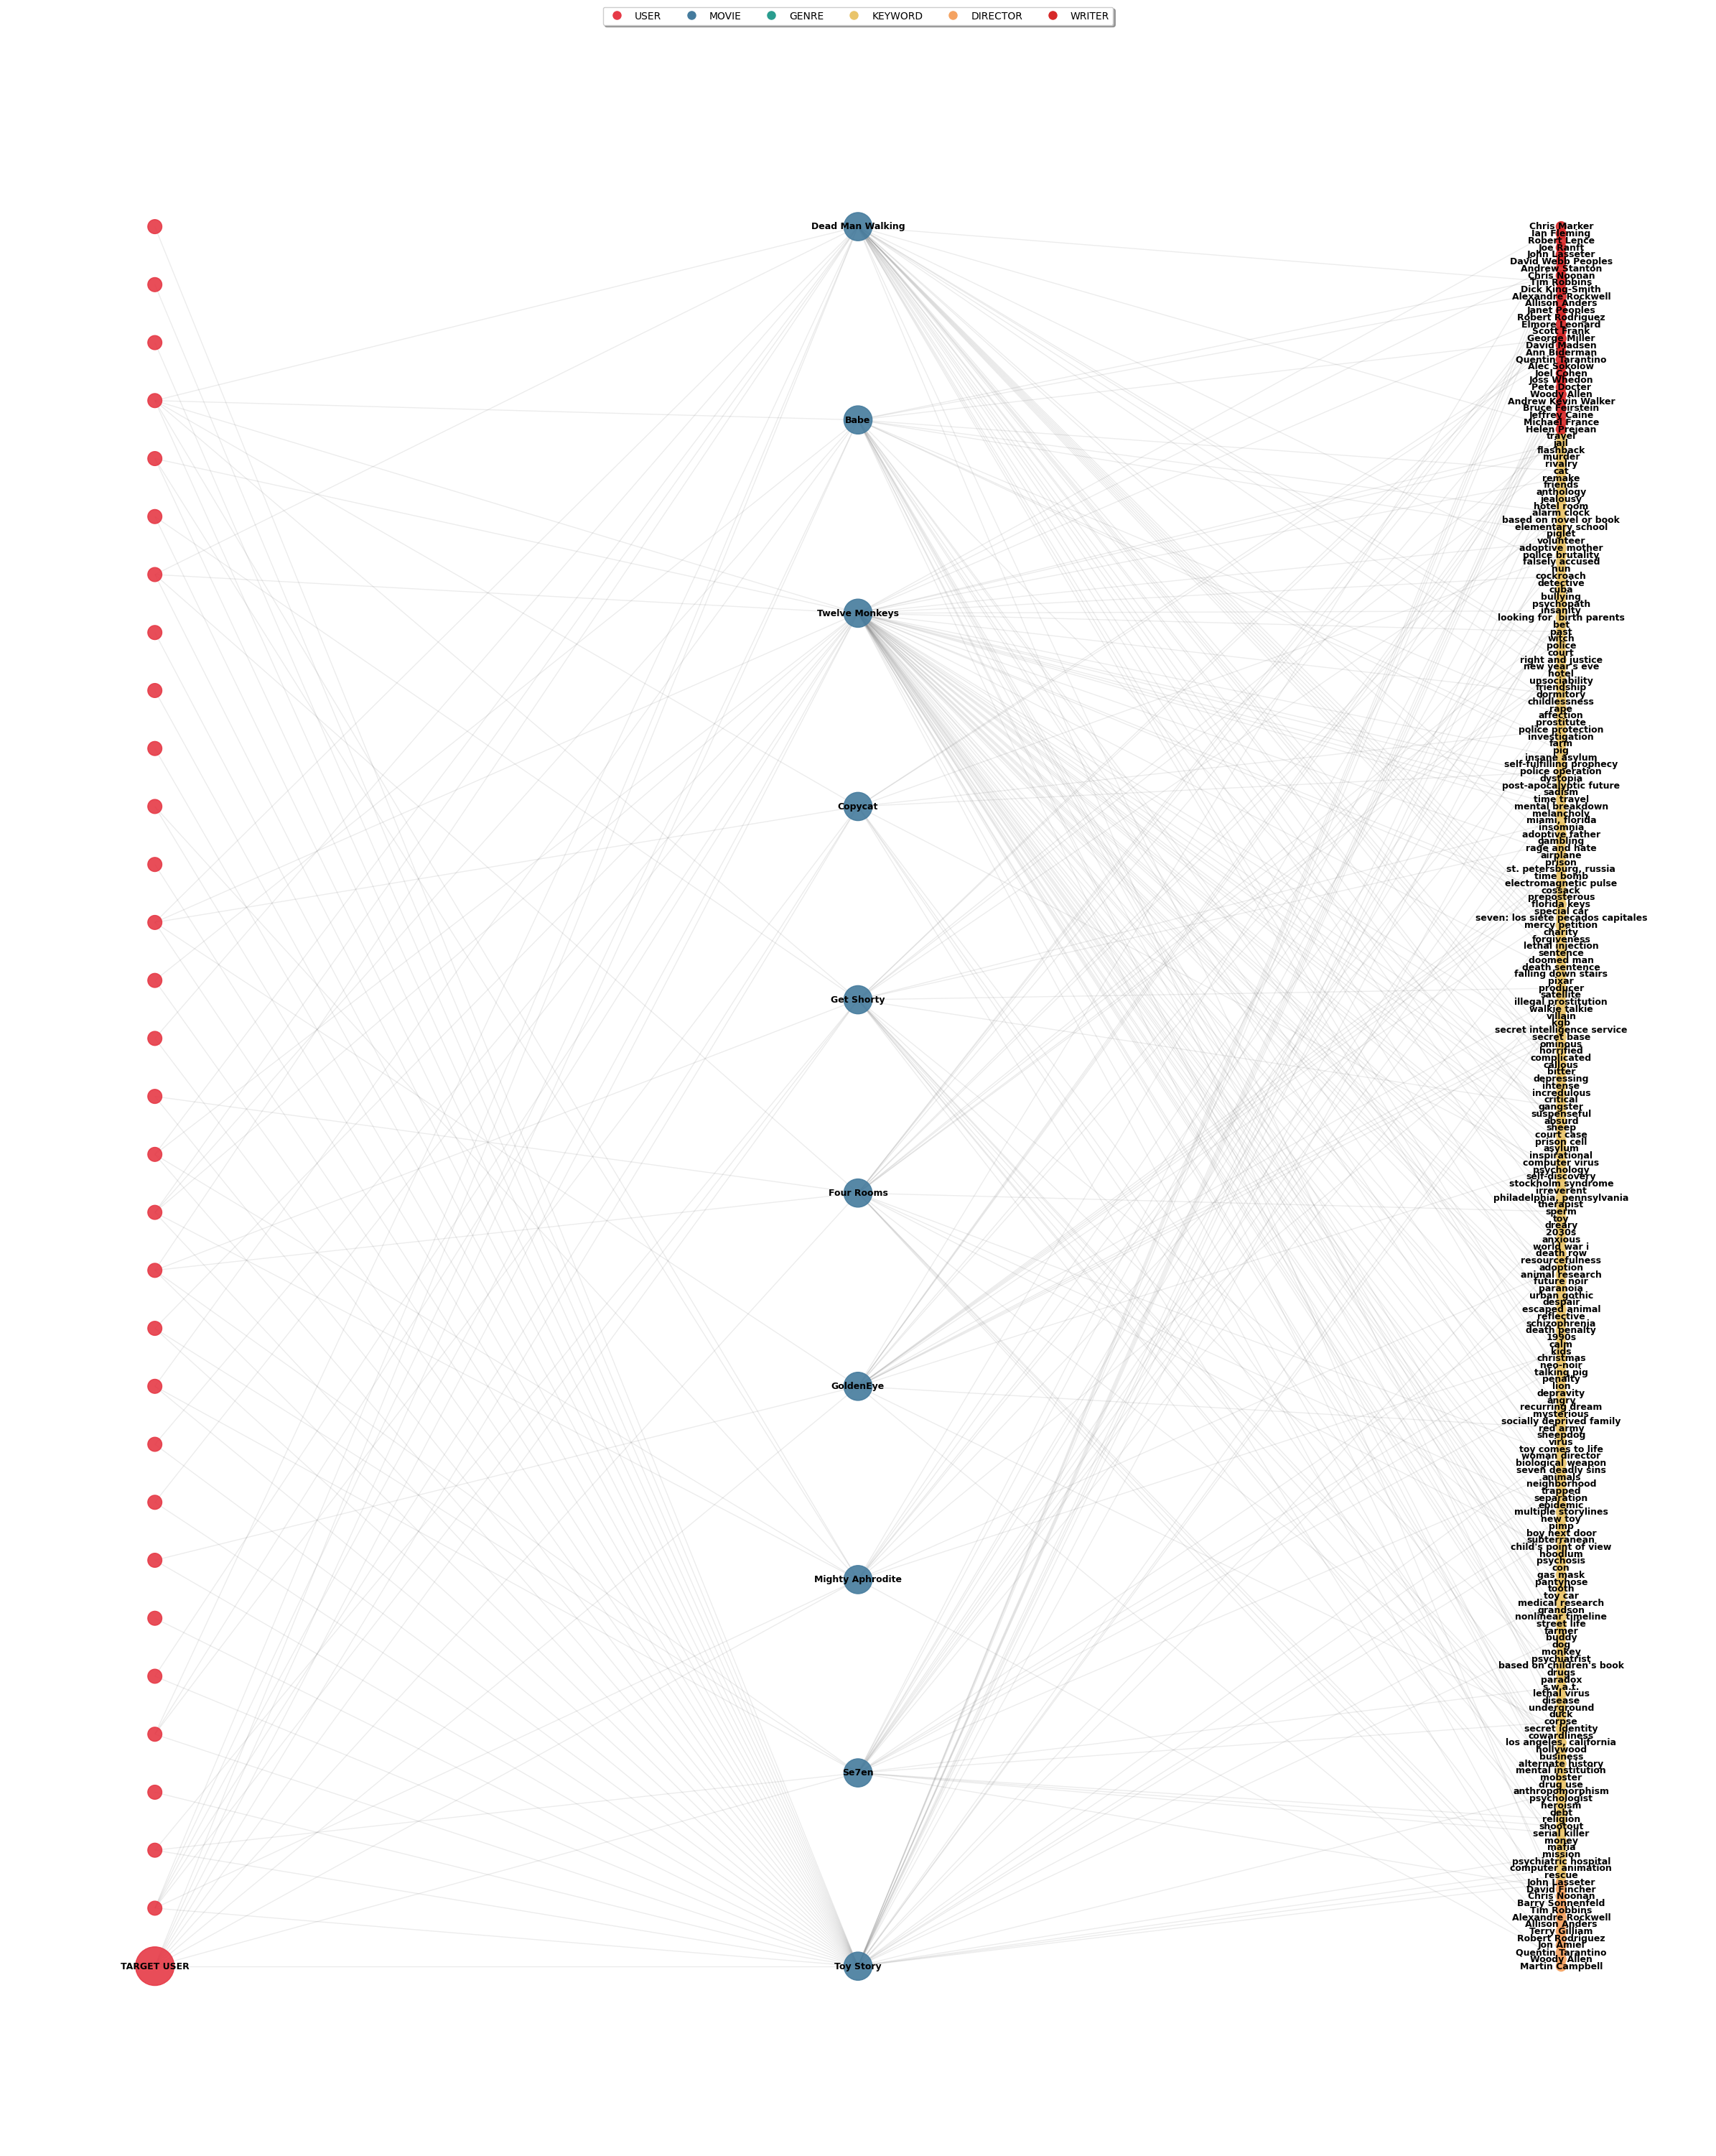

In [38]:
def visualize_tripartite_neighborhood(graph, user_id):
    target_user = f"user_{user_id}"
    
    if not graph.has_node(target_user):
        print(f"User {user_id} not found.")
        return

    print(f"Extracting neighborhood for User {user_id}...")
    
    # 1. Identify Nodes for Subgraph
    
    # Neighbors of Target User (Movies Watched)
    movies_watched = list(graph.neighbors(target_user))
    
    # Sample movies to keep plot readable (limit to 10 movies for this view)
    movies_to_plot = movies_watched[:10] 
    
    subgraph_nodes = {target_user}
    subgraph_nodes.update(movies_to_plot)
    
    # Fetch secondary connections (Attributes and Other Users)
    other_users = set()
    attributes = set()

    for m in movies_to_plot:
        neighbors = list(graph.neighbors(m))
        for n in neighbors:
            ntype = graph.nodes[n].get('type')
            
            # If it's a user (who isn't the target), add to "Other Users" list
            if ntype == 'user' and n != target_user:
                if len(other_users) < 30: # HARD LIMIT to prevent clutter
                    other_users.add(n)
            
            # If it's an attribute, add to Attributes list
            elif ntype in ['genre', 'keyword', 'director', 'writer']:
                attributes.add(n)
    
    subgraph_nodes.update(other_users)
    subgraph_nodes.update(attributes)
    
    # Create subgraph
    subG = graph.subgraph(subgraph_nodes)
    
    # 2. Calculate Positions (Tripartite Layout)
    pos = {}
    
    # Group nodes by column
    # Target user goes in the middle of the User column
    col_users = list(other_users) + [target_user]
    col_movies = movies_to_plot
    col_attrs = list(attributes)
    
    # Sort for visual consistency
    col_users.sort()
    col_movies.sort()
    col_attrs.sort() # Ideally sort by type, then name
    
    # Helper to assign (x, y)
    def assign_column_positions(nodes, x_val):
        n = len(nodes)
        if n == 0: return
        # Linear spacing from y=0.05 to y=0.95 to use full height
        ys = np.linspace(0.05, 0.95, n)
        for i, node in enumerate(nodes):
            pos[node] = np.array([x_val, ys[i]])

    # Assign X coordinates: Users=0, Movies=1, Attributes=2
    assign_column_positions(col_users, 0)
    assign_column_positions(col_movies, 1)
    assign_column_positions(col_attrs, 2)
    
    # 3. Visualization
    # CHANGED: Increased figsize from (20, 12) to (24, 30) for vertical space
    plt.figure(figsize=(24, 30))
    
    # Colors
    type_colors = {
        'user': '#e63946',      # Red
        'movie': '#457b9d',     # Blue
        'genre': '#2a9d8f',     # Teal
        'keyword': '#e9c46a',   # Yellow/Orange
        'director': '#f4a261',  # Orange
        'writer': '#d62828'     # Dark Red
    }
    
    # Draw Edges (Light grey background lines)
    nx.draw_networkx_edges(subG, pos, alpha=0.15, edge_color='gray')
    
    # Draw Nodes by Type
    for ntype in ['user', 'movie', 'attribute']:
        if ntype == 'attribute':
            nodelist = col_attrs
            size = 100
        elif ntype == 'movie':
            nodelist = col_movies
            size = 800
        else:
            nodelist = col_users
            size = 200 # Small for other users
            
        if not nodelist: continue
        
        # Color map for this batch
        colors = [type_colors.get(subG.nodes[n].get('type'), '#cccccc') for n in nodelist]
        
        # Highlight target user
        sizes = []
        for n in nodelist:
            if n == target_user: sizes.append(1500)
            else: sizes.append(size)
            
        nx.draw_networkx_nodes(subG, pos, nodelist=nodelist, node_color=colors, node_size=sizes, alpha=0.9)
    
    # Draw Labels
    labels = {}
    for node in subG.nodes():
        ntype = subG.nodes[node].get('type')
        
        # Label Logic:
        # 1. Target User: ALWAYS label
        # 2. Movies: ALWAYS label (Title)
        # 3. Attributes: ALWAYS label (Name)
        # 4. Other Users: NEVER label (Reduces clutter)
        
        if node == target_user:
            labels[node] = "TARGET USER"
        elif ntype == 'user':
            continue 
        elif ntype == 'movie':
            labels[node] = subG.nodes[node].get('title', node)
        else:
            labels[node] = subG.nodes[node].get('name', node)
            
    nx.draw_networkx_labels(subG, pos, labels, font_size=9, font_weight='bold', font_family='sans-serif')
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=k.upper(),
                          markerfacecolor=v, markersize=10) for k, v in type_colors.items()]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02),
              ncol=len(type_colors), fancybox=True, shadow=True)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run visualization for User 1
visualize_tripartite_neighborhood(G, 1)

## 10. Save Graph
Save the graph to disk for later use. GraphML is a standard format supported by Gephi and other tools

In [39]:
print("Saving graph to 'data/processed/movie_knowledge_graph.graphml'...")
# Ensure directory exists
os.makedirs('../data/processed', exist_ok=True)

# Note: GraphML does not support list attributes natively. 
# Since our graph uses explicit nodes for list-like properties (genres, keywords), 
# we don't have complex node attributes to worry about, so this will work perfectly.
nx.write_graphml(G, "../data/processed/movie_knowledge_graph.graphml")
print("Graph saved successfully.")

Saving graph to 'data/processed/movie_knowledge_graph.graphml'...
Graph saved successfully.
